

## **Importation des bibliothèques & fichier**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path="/content/drive/MyDrive/Projet 12/"

In [ ]:
billets=pd.read_csv(path+'billets.csv',sep=";")
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


## 2)Analyse exploratoire des données

### A) Gestion des valeurs manquantes

###### a) Nombre de vrai & Faux billets

In [ ]:
vrai_billets=billets[billets["is_genuine"]==True]
faux_billets=billets[billets["is_genuine"]==False]
print(f"Nombre de vrai billets: {vrai_billets.shape[0]}")
print(f"Nombre de faux billets: {faux_billets.shape[0]}")

Nombre de vrai billets: 1000
Nombre de faux billets: 500


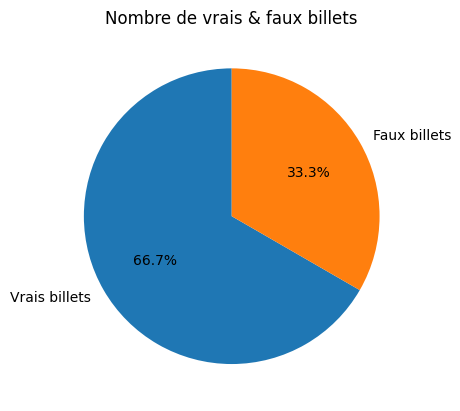

In [ ]:
billets["is_genuine"].value_counts().plot(kind="pie", labels=["Vrais billets","Faux billets"],autopct="%1.1f%%",startangle=90)
plt.title("Nombre de vrais & faux billets")
plt.ylabel("")
plt.show()

##### b) Valeurs vides

In [ ]:
print(billets.isna().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


###### b) Analyse des valeurs vides

In [ ]:
nb_na_vrai_billets=vrai_billets.isna().any(axis=1).sum()
nb_na_faux_billets=faux_billets.isna().any(axis=1).sum()
print(f"Vrais billets, nombre de valeurs manquantes : {nb_na_vrai_billets}")
print(f"Faux billets , nombre de valeurs manquantes : {nb_na_faux_billets}")

Vrais billets, nombre de valeurs manquantes : 29
Faux billets , nombre de valeurs manquantes : 8


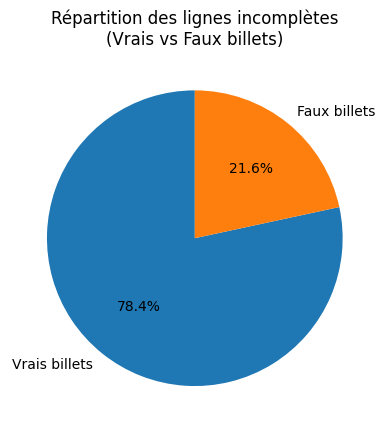

In [ ]:
lignes_avec_nan = billets.isna().any(axis=1)

nb_nan_par_type = billets[lignes_avec_nan]["is_genuine"].value_counts()

nb_nan_par_type.plot(
    kind="pie",
    labels=["Vrais billets", "Faux billets"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Répartition des lignes incomplètes\n(Vrais vs Faux billets)")
plt.ylabel("")
plt.show()

##### c) Détermination des variables corrélés à margin low

In [ ]:
corr_matrix = billets.corr()
corr_margin_low = corr_matrix["margin_low"].drop("margin_low")
corr_margin_low.sort_values(ascending=False)

,margin_low
margin_up,0.431606
height_right,0.391085
height_left,0.302643
diagonal,-0.111534
length,-0.666753
is_genuine,-0.783032


Nous allons utiliser : margin up , height_right , height left , length car les corrélations sont suffisaments élevées pour être utiliser lors de la régression linéaire. Nous allons exclure is_genuie et diagonal.

##### d) Entrainement du modèle de régression linéraire pour imputaion (tout billets confondus

In [ ]:
from sklearn.linear_model import LinearRegression
billets_complets=billets[billets["margin_low"].notna()]
billets_incomplets=billets[billets['margin_low'].isna()]

features=["margin_up","height_right","height_left","length"]
X_train=billets_complets[features]
Y_train= billets_complets["margin_low"]
features=["margin_up","height_right","height_left","length"]

model=LinearRegression()
model.fit(X_train,Y_train)


LinearRegression()

In [ ]:
r2 = model.score(X_train, Y_train)
print("R² =", r2)

R² = 0.47476007148337607


##### Tests statistiques

###### Normalité des résidus

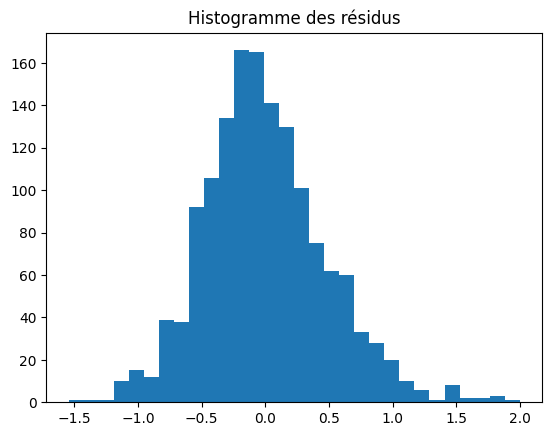

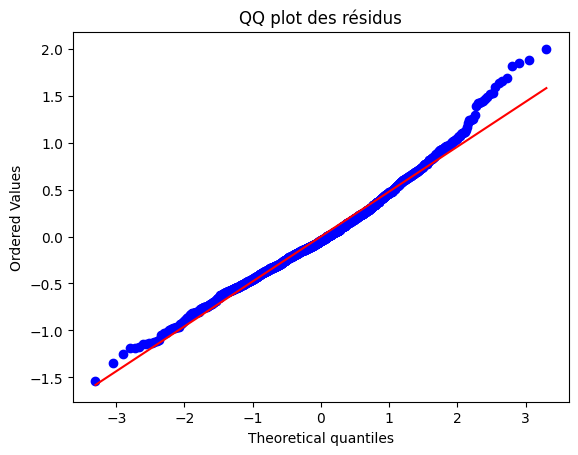

p-value Shapiro: 5.934770946123494e-11
Les résidus ne sont pas normalement distribués.


In [ ]:
import scipy.stats as stats

residus =  Y_train - model.predict(X_train)

# Histogramme
plt.hist(residus, bins=30)
plt.title("Histogramme des résidus")
plt.show()

# QQ plot
stats.probplot(residus, dist="norm", plot=plt)
plt.title("QQ plot des résidus")
plt.show()

# Test de Shapiro
stat, p = stats.shapiro(residus)
print("p-value Shapiro:", p)

if p > 0.05:
    print("Les résidus suivent une loi normale.")
else:
    print("Les résidus ne sont pas normalement distribués.")

###### Collinéalité

In [ ]:
X_train.columns

Index(['margin_up', 'height_right', 'height_left', 'length'], dtype='object')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["variables"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(X_train.shape[1])]
print(vif_data)

      variables           VIF
0     margin_up    261.957761
1  height_right  75363.099336
2   height_left  80852.421037
3        length  16774.809970


In [ ]:
X_train.describe()

,margin_up,height_right,height_left,length
count,1463.000000,1463.000000,1463.000000,1463.000000
mean,3.153083,103.921476,104.031333,112.674757
std,0.231466,0.324181,0.299605,0.873222
min,2.270000,102.910000,103.140000,109.490000
25%,2.990000,103.710000,103.825000,112.020000
50%,3.140000,103.920000,104.040000,112.960000
75%,3.315000,104.150000,104.230000,113.340000
max,3.910000,104.950000,104.880000,114.320000


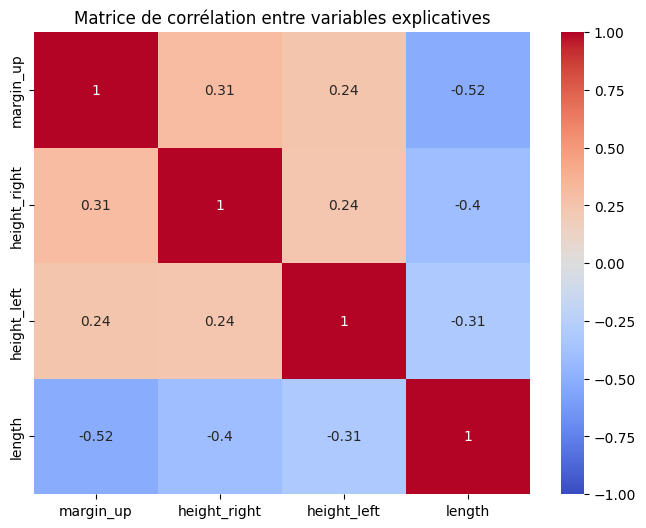

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation entre variables explicatives")
plt.show()

###### L'homoscédosticité

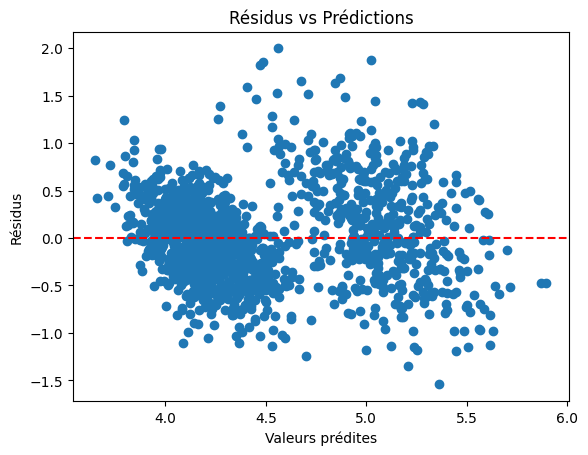

p-value Breusch-Pagan: 1.398151993844129e-16
Hétéroscedasticité détectée


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

y_pred = model.predict(X_train)
residus = Y_train - y_pred

plt.scatter(y_pred, residus)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Prédictions")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.show()

X_train_sm = sm.add_constant(X_train)
test = het_breuschpagan(residus, X_train_sm)
pval = test[1]
print("p-value Breusch-Pagan:", pval)

if pval > 0.05:
    print("Homoscedasticité respectée")
else:
    print("Hétéroscedasticité détectée")

##### f) Entrainement du modèle de régression linéraire seulement VRAIS BILLETS

In [ ]:
billets_vrais_complets=billets_complets[billets_complets["is_genuine"]==True]

In [ ]:
X_train=billets_vrais_complets[features]
Y_train= billets_vrais_complets["margin_low"]
features=["margin_up","height_right","height_left","length"]

model=LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

In [ ]:
r2 = model.score(X_train, Y_train)
print("R² =", r2)

R² = 0.006596989871683223


##### Test Statistiques

###### Normalité des individus

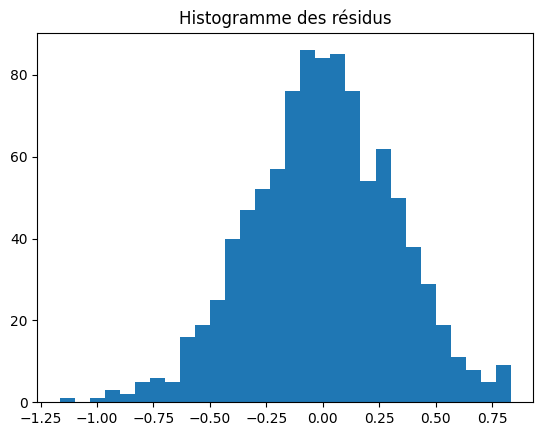

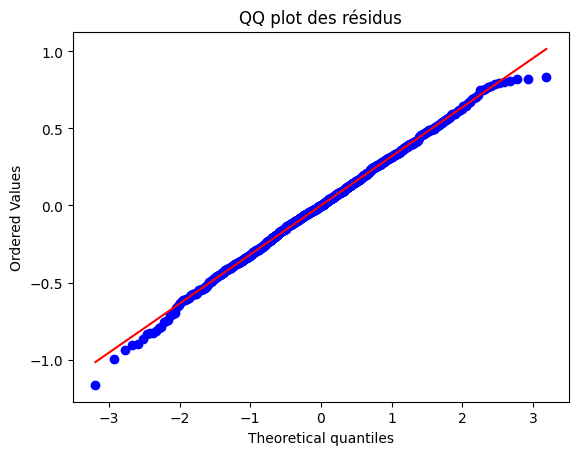

p-value Shapiro: 0.33550073964140004
Les résidus suivent une loi normale.


In [ ]:

residus =  Y_train - model.predict(X_train)

plt.hist(residus, bins=30)
plt.title("Histogramme des résidus")
plt.show()

stats.probplot(residus, dist="norm", plot=plt)
plt.title("QQ plot des résidus")
plt.show()

stat, p = stats.shapiro(residus)
print("p-value Shapiro:", p)

if p > 0.05:
    print("Les résidus suivent une loi normale.")
else:
    print("Les résidus ne sont pas normalement distribués.")

###### Collinéalité

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["variables"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(X_train.shape[1])]
print(vif_data)

      variables           VIF
0     margin_up    272.810937
1  height_right  86676.092920
2   height_left  81152.268563
3        length  72100.459760


###### Homoscédicité

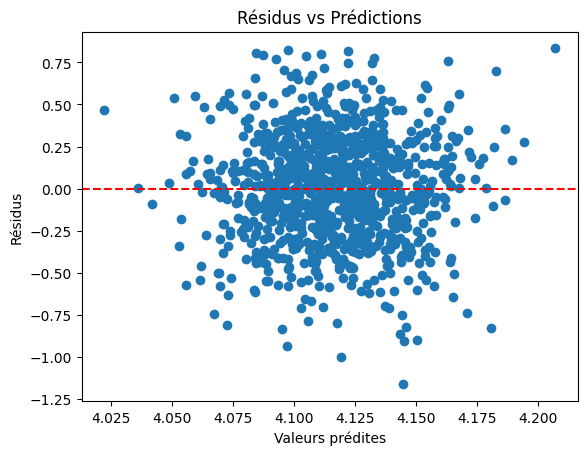

p-value Breusch-Pagan: 0.6112482772044727
Homoscedasticité respectée


In [ ]:
y_pred = model.predict(X_train)
residus = Y_train - y_pred

plt.scatter(y_pred, residus)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Prédictions")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.show()

# Test de Breusch-Pagan
X_train_sm = sm.add_constant(X_train)
test = het_breuschpagan(residus, X_train_sm)
pval = test[1]
print("p-value Breusch-Pagan:", pval)

if pval > 0.05:
    print("Homoscedasticité respectée")
else:
    print("Hétéroscedasticité détectée")

Imputation des valeurs des vrais billets

In [ ]:
billets_vrais_incomplets = billets[(billets["is_genuine"] == 1) & (billets["margin_low"].isna())]

X_missing = billets_vrais_incomplets[features].dropna()

billets_vrais_incomplets = billets_vrais_incomplets.loc[X_missing.index]


predicted_margin_low = model.predict(X_missing)

billets_imputes = billets.copy()

billets_imputes.loc[X_missing.index, "margin_low"] = predicted_margin_low

g)  Entrainement du modèle de régression linéraire pour imputaion seulement FAUX BILLETS

In [ ]:
billets_faux_complets=billets_complets[billets_complets["is_genuine"]==False]

In [ ]:
X_train=billets_faux_complets[features]
Y_train= billets_faux_complets["margin_low"]
features=["margin_up","height_right","height_left","length"]
model=LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

In [ ]:
r2 = model.score(X_train, Y_train)
print("R² =", r2)

R² = 0.022966966166812153


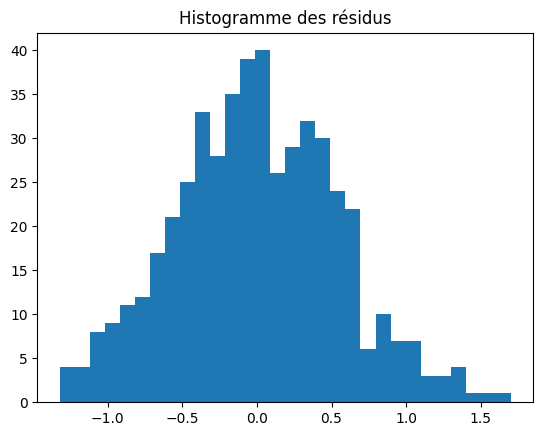

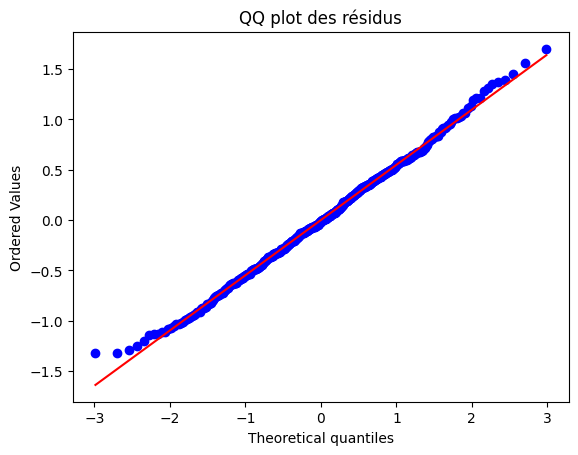

p-value Shapiro: 0.47686923791631436
Les résidus suivent une loi normale.


In [ ]:
residus =  Y_train - model.predict(X_train)

plt.hist(residus, bins=30)
plt.title("Histogramme des résidus")
plt.show()

stats.probplot(residus, dist="norm", plot=plt)
plt.title("QQ plot des résidus")
plt.show()

# Test de Shapiro
stat, p = stats.shapiro(residus)
print("p-value Shapiro:", p)

if p > 0.05:
    print("Les résidus suivent une loi normale.")
else:
    print("Les résidus ne sont pas normalement distribués.")

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["variables"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(X_train.shape[1])]
print(vif_data)

      variables            VIF
0     margin_up     352.863749
1  height_right  101601.117077
2   height_left  107299.842279
3        length   30473.115339


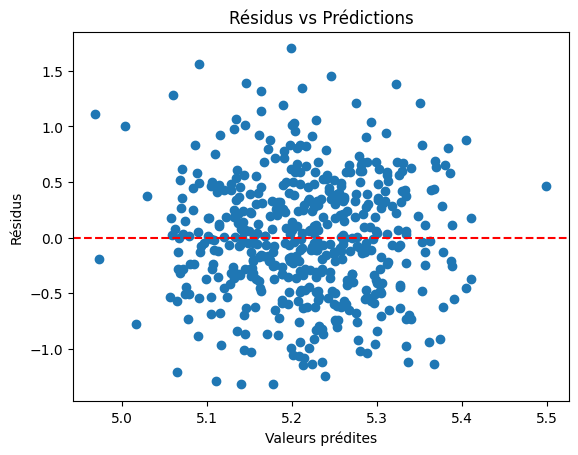

p-value Breusch-Pagan: 0.9926559097058159
Homoscedasticité respectée


In [ ]:

y_pred = model.predict(X_train)
residus = Y_train - y_pred

plt.scatter(y_pred, residus)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs Prédictions")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.show()

# Test de Breusch-Pagan
X_train_sm = sm.add_constant(X_train)
test = het_breuschpagan(residus, X_train_sm)
pval = test[1]
print("p-value Breusch-Pagan:", pval)

if pval > 0.05:
    print("Homoscedasticité respectée")
else:
    print("Hétéroscedasticité détectée")

Imputation valeurs Faux billets

In [ ]:
billets_faux_incomplets = billets[(billets["is_genuine"] == 0) & (billets["margin_low"].isna())]

X_missing = billets_faux_incomplets[features].dropna()

billets_faux_incomplets = billets_faux_incomplets.loc[X_missing.index]


predicted_margin_low = model.predict(X_missing)

billets_imputes.loc[X_missing.index, "margin_low"] = predicted_margin_low
billets=billets_imputes

In [ ]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


### B) Analyse Descriptive général

##### 0) Fonctions exploratoires

In [ ]:
def tracer_histogrammes(df,col):
  plt.figure(figsize=(6, 4))
  sns.histplot(df[col], kde=True, color='skyblue')
  plt.title(f"Distribution de {col}")
  plt.xlabel(col)
  plt.ylabel("Fréquence")
  plt.show()

def tracer_boxplots(df,col):
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df[col], color='lightcoral')
  plt.title(f"Boxplot de {col}")
  plt.show()

def detecter_outliers(df, col):
    print("Valeurs aberrantes détectées :")
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr_val = q3 - q1
    lower = q1 - 1.5 * iqr_val
    upper = q3 + 1.5 * iqr_val
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} : {len(outliers)} outliers")



def analyse_par_classe(df, col, target):
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=target, y=col, data=df, palette="Set2")
  plt.title(f"{col} par classe(Vrai/Faux)")
  plt.show()


def fonction_exploratrice(df,col,target) :

  tracer_histogrammes(df,col)
  tracer_boxplots(df,col)
  detecter_outliers(df,col)
  analyse_par_classe(df,col,target)

##### a) Corrélation

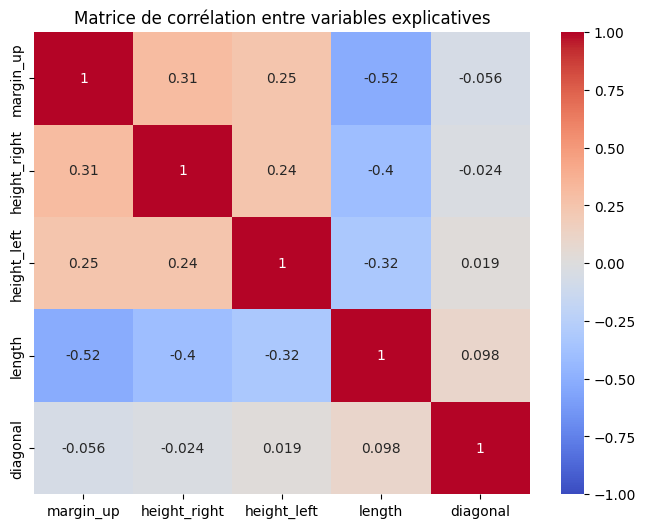

In [ ]:
features=["margin_up","height_right","height_left","length","diagonal"]
corr_matrix=billets[features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation entre variables explicatives")
plt.show()



##### c) analyse descriptives variables

###### général

In [ ]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482970,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.660105,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.030000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


###### diagonal

In [ ]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


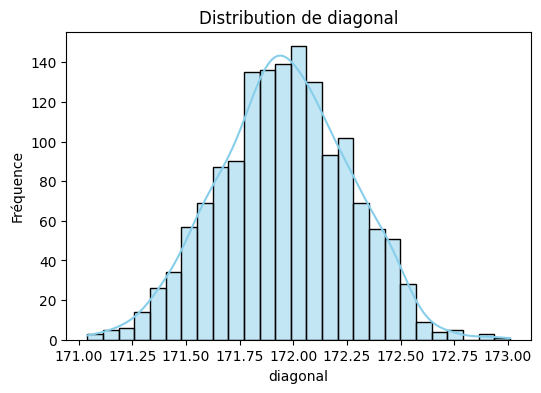

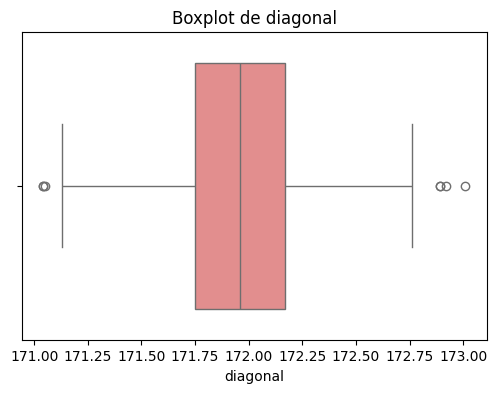

Valeurs aberrantes détectées :
diagonal : 7 outliers


/tmp/ipython-input-1210-2840684878.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




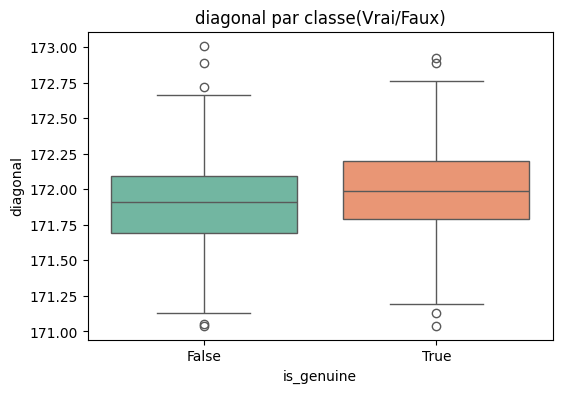

In [ ]:
fonction_exploratrice(billets,"diagonal","is_genuine")

height_left

In [ ]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


###### height_right

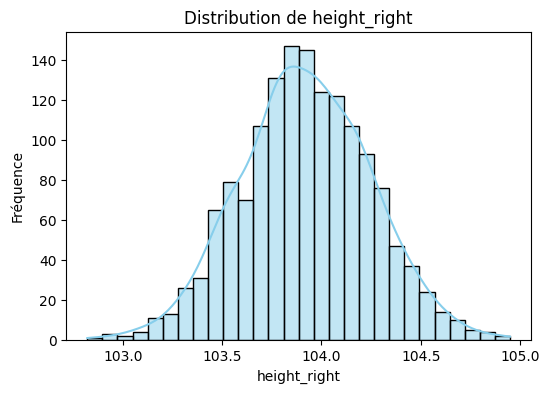

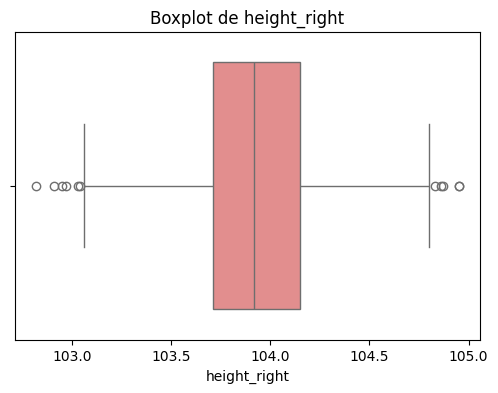

Valeurs aberrantes détectées :
height_right : 11 outliers


/tmp/ipython-input-1210-2840684878.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




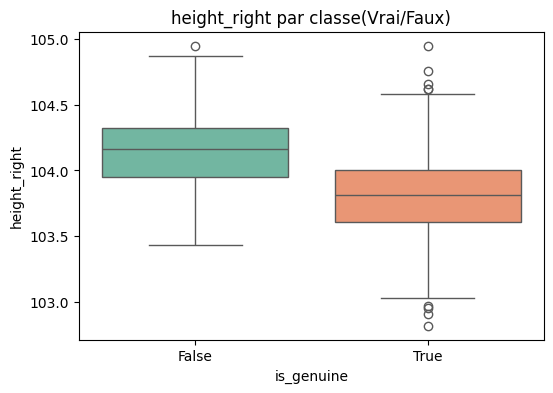

In [ ]:
fonction_exploratrice(billets,"height_right","is_genuine")

###### margin_low

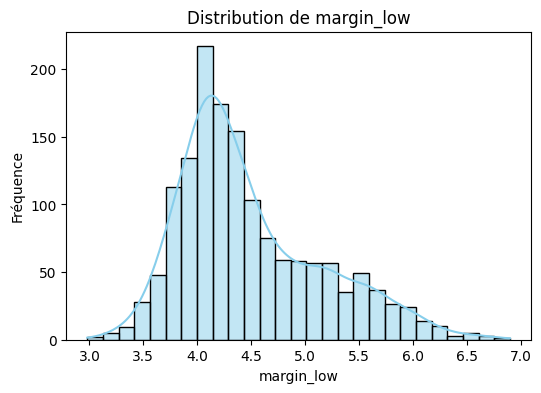

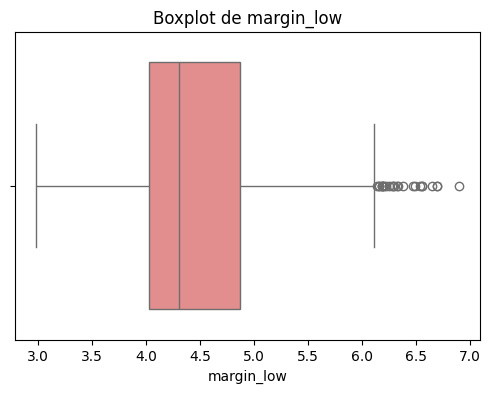

Valeurs aberrantes détectées :
margin_low : 25 outliers


/tmp/ipython-input-1210-2840684878.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




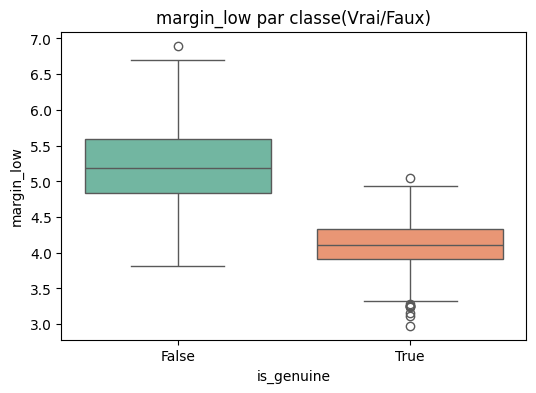

In [ ]:
fonction_exploratrice(billets,"margin_low","is_genuine")

###### margin_up

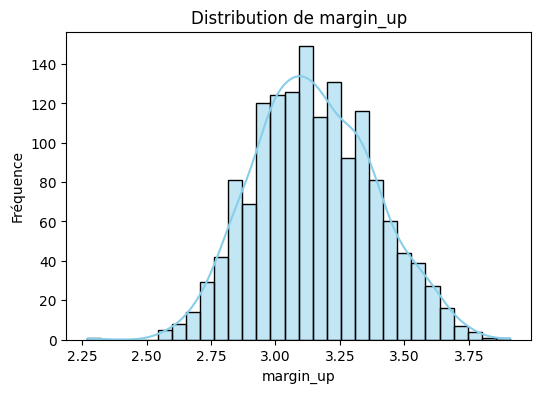

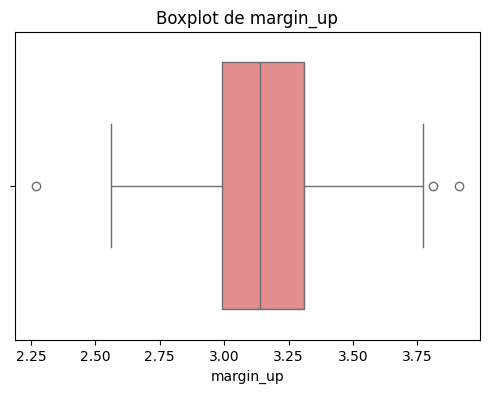

Valeurs aberrantes détectées :
margin_up : 3 outliers


/tmp/ipython-input-1210-2840684878.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




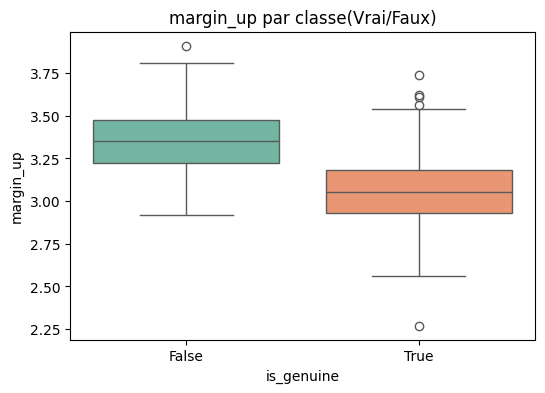

In [ ]:
fonction_exploratrice(billets,"margin_up","is_genuine")

###### length

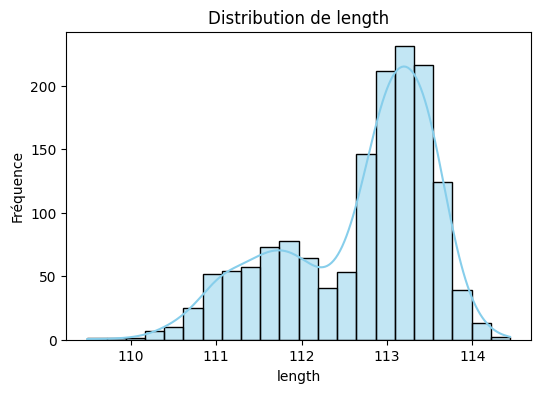

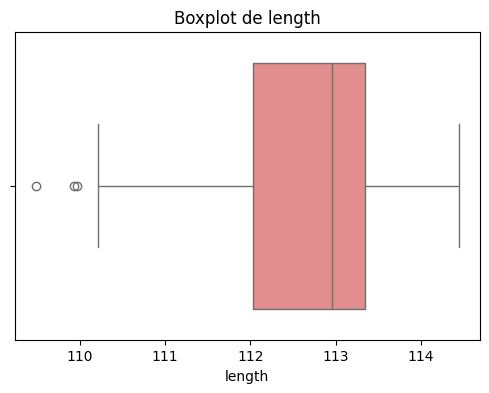

Valeurs aberrantes détectées :
length : 3 outliers


/tmp/ipython-input-1210-2840684878.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




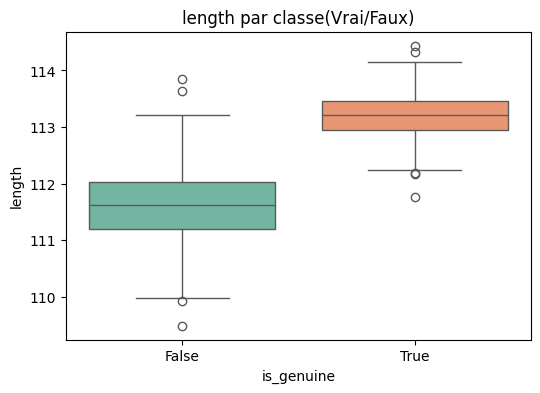

In [ ]:
fonction_exploratrice(billets,"length","is_genuine")

###### height left

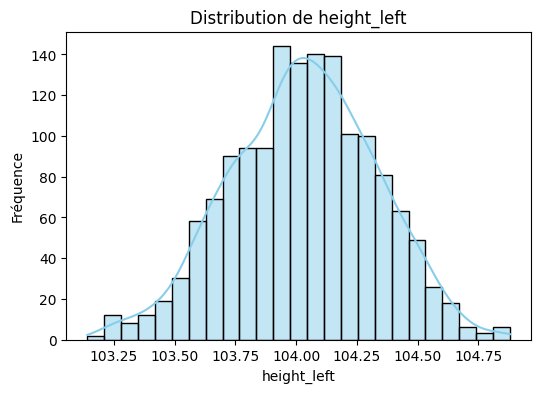

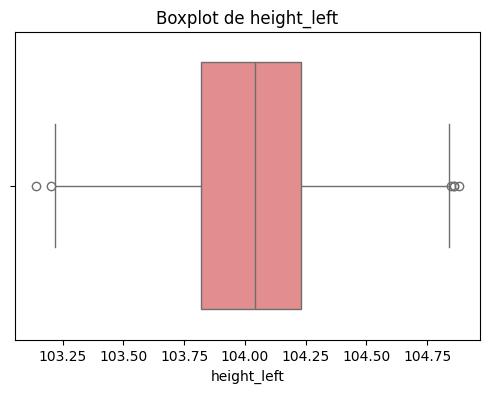

Valeurs aberrantes détectées :
height_left : 6 outliers


/tmp/ipython-input-1210-2840684878.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




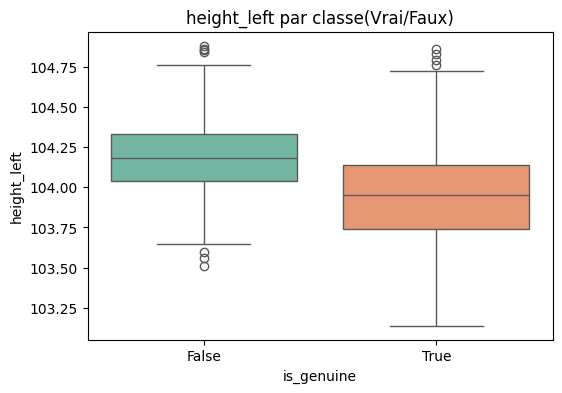

In [ ]:
fonction_exploratrice(billets,"height_left","is_genuine")

### C) Analyse par composantes principales

###### a) Détermination du nombre de composante principales

In [ ]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


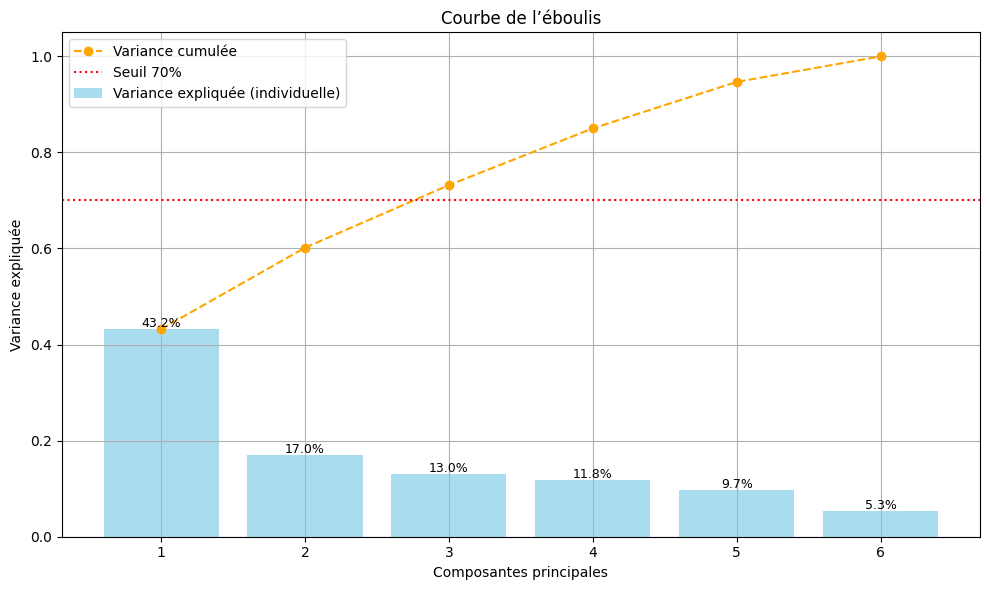

In [ ]:
from sklearn.decomposition import PCA

X=billets.drop(columns=["is_genuine"])
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
pca_full=PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))

bars = plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, label="Variance expliquée (individuelle)", color='skyblue')

for i, v in enumerate(explained_var):
    plt.text(i + 1, v + 0.005, f"{v*100:.1f}%", ha='center', fontsize=9)

plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, color='orange', marker='o', linestyle='--', label="Variance cumulée")
plt.axhline(y=0.70, color='r', linestyle=':', label='Seuil 70%')

plt.title("Courbe de l’éboulis")
plt.xlabel("Composantes principales")
plt.ylabel("Variance expliquée")
plt.xticks(range(1, len(explained_var) + 1))
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### c) Cercle des corrélations

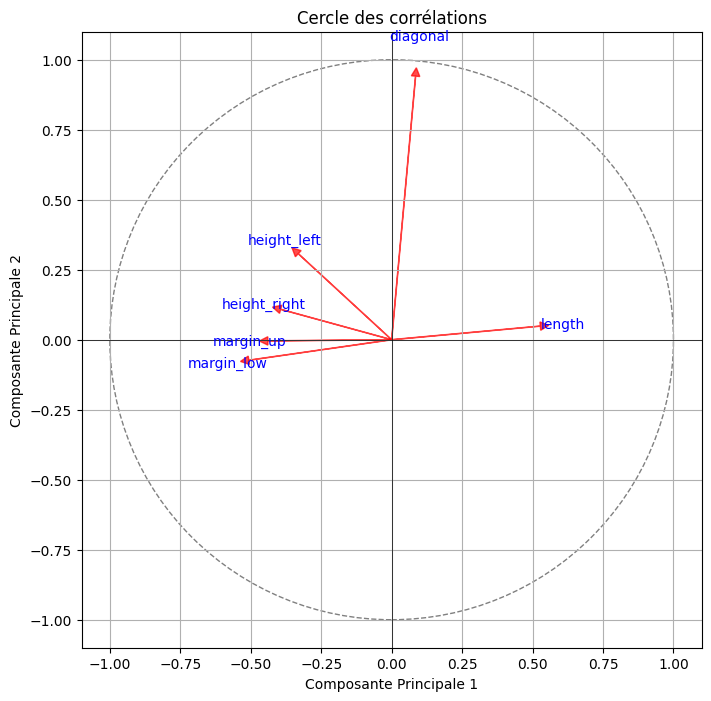

In [ ]:
pcs = pca_full.components_

pc1 = pcs[0, :]
pc2 = pcs[1, :]

variables = X.columns

plt.figure(figsize=(8,8))

circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

for i in range(len(variables)):
    plt.arrow(0, 0, pc1[i], pc2[i], color='r', alpha=0.7, head_width=0.03, head_length=0.03)
    plt.text(pc1[i]*1.15, pc2[i]*1.15, variables[i], color='b', ha='center', va='center')

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title("Cercle des corrélations")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()

In [ ]:
cos2 = pc1**2 + pc2**2

results_table = pd.DataFrame({
    "Variable": variables,
    "PC1": pc1,
    "PC2": pc2,
    "Cos²": cos2
})

results_table = results_table.round(3)

from IPython.display import display

display(results_table.style.background_gradient(cmap='coolwarm'))

,Variable,PC1,PC2,Cos²
0,diagonal,0.085000,0.941000,0.893000
1,height_left,-0.331000,0.307000,0.204000
2,height_right,-0.394000,0.109000,0.167000
3,margin_low,-0.507000,-0.073000,0.262000
4,margin_up,-0.439000,-0.004000,0.193000
5,length,0.527000,0.049000,0.281000


##### b) Projection des individus sur les composantes principales

In [ ]:
import plotly.express as px
import pandas as pd

df_proj = pd.DataFrame({
    "PC1": X_pca_full[:, 0],
    "PC2": X_pca_full[:, 1],
    "is_genuine": billets["is_genuine"].values
})

fig = px.scatter(
    df_proj, x="PC1", y="PC2",
    color="is_genuine",
    title="Projection des billets classés sur PC1 et PC2",
    labels={"PC1": "Composante Principale 1", "PC2": "Composante Principale 2"},
    color_discrete_map={True: "green", False: "red"},
    opacity=0.7,
    width=900,
    height=900
)

fig.update_layout(
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1)
)

fig.show()

## 3) Création IA détection billets

### A) Préparation des données pour la "Validation croisée"

In [ ]:
from sklearn.model_selection import StratifiedKFold

X = billets.drop(columns=["is_genuine"])
y = billets["is_genuine"]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"Fold {fold}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print("Train class counts:")
    print(y_train.value_counts())
    print("Train class proportions:")
    print(y_train.value_counts(normalize=True))

    print("Test class counts:")
    print(y_test.value_counts())
    print("Test class proportions:")
    print(y_test.value_counts(normalize=True))
    print("-" * 30)

Fold 1
Train class counts:
is_genuine
True     900
False    450
Name: count, dtype: int64
Train class proportions:
is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64
Test class counts:
is_genuine
True     100
False     50
Name: count, dtype: int64
Test class proportions:
is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64
------------------------------
Fold 2
Train class counts:
is_genuine
True     900
False    450
Name: count, dtype: int64
Train class proportions:
is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64
Test class counts:
is_genuine
True     100
False     50
Name: count, dtype: int64
Test class proportions:
is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64
------------------------------
Fold 3
Train class counts:
is_genuine
True     900
False    450
Name: count, dtype: int64
Train class proportions:
is_genuine
True     0.666667
False    0.333333
Name: proporti

### B) Régression logistique

##### Entrainement


Fold 1:
Train - Acc: 0.993, Prec: 0.991, Rec: 0.998, F1: 0.994
Test  - Acc: 0.993, Prec: 1.000, Rec: 0.990, F1: 0.995

Fold 2:
Train - Acc: 0.993, Prec: 0.991, Rec: 0.998, F1: 0.994
Test  - Acc: 0.993, Prec: 0.990, Rec: 1.000, F1: 0.995

Fold 3:
Train - Acc: 0.995, Prec: 0.993, Rec: 0.999, F1: 0.996
Test  - Acc: 0.980, Prec: 0.980, Rec: 0.990, F1: 0.985

Fold 4:
Train - Acc: 0.993, Prec: 0.991, Rec: 0.998, F1: 0.994
Test  - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000

Fold 5:
Train - Acc: 0.993, Prec: 0.992, Rec: 0.997, F1: 0.994
Test  - Acc: 0.980, Prec: 0.971, Rec: 1.000, F1: 0.985

Fold 6:
Train - Acc: 0.992, Prec: 0.991, Rec: 0.997, F1: 0.994
Test  - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000

Fold 7:
Train - Acc: 0.993, Prec: 0.992, Rec: 0.997, F1: 0.994
Test  - Acc: 0.993, Prec: 0.990, Rec: 1.000, F1: 0.995

Fold 8:
Train - Acc: 0.991, Prec: 0.990, Rec: 0.997, F1: 0.993
Test  - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000

Fold 9:
Train - Acc: 0.994, Prec: 0.992, Rec: 0

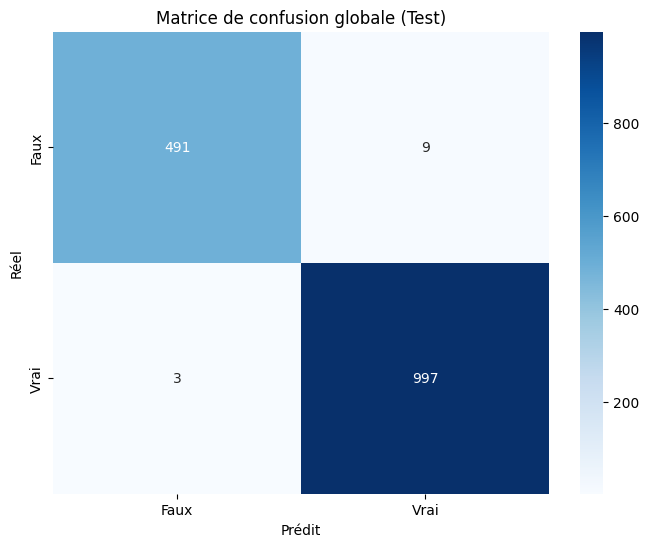

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Initialisation
model = LogisticRegression(max_iter=1000, random_state=42)
scaler = StandardScaler()

# 2. Stockage des résultats
results = {
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_rec': [], 'test_rec': [],
    'train_f1': [], 'test_f1': []
}
y_true_all = []
y_pred_all = []

# 3. Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test)

    results['train_acc'].append(accuracy_score(y_train, y_pred_train))
    results['train_prec'].append(precision_score(y_train, y_pred_train))
    results['train_rec'].append(recall_score(y_train, y_pred_train))
    results['train_f1'].append(f1_score(y_train, y_pred_train))

    results['test_acc'].append(accuracy_score(y_test, y_pred_test))
    results['test_prec'].append(precision_score(y_test, y_pred_test))
    results['test_rec'].append(recall_score(y_test, y_pred_test))
    results['test_f1'].append(f1_score(y_test, y_pred_test))

    print(f"\nFold {fold}:")
    print(f"Train - Acc: {results['train_acc'][-1]:.3f}, Prec: {results['train_prec'][-1]:.3f}, Rec: {results['train_rec'][-1]:.3f}, F1: {results['train_f1'][-1]:.3f}")
    print(f"Test  - Acc: {results['test_acc'][-1]:.3f}, Prec: {results['test_prec'][-1]:.3f}, Rec: {results['test_rec'][-1]:.3f}, F1: {results['test_f1'][-1]:.3f}")

# 4. Analyse des écarts
print("\n" + "="*60)
print("RÉSULTATS GLOBAUX".center(60))
print("="*60)

print("\n=== PERFORMANCES MOYENNES ===")
print(f"{'Métrique':<12} | {'Train':^8} | {'Test':^8} | {'Gap':^8} | {'Écart-type (Test)':^15}")
print("-"*60)
for metric in ['acc', 'prec', 'rec', 'f1']:
    train_mean = np.mean(results[f'train_{metric}'])
    test_mean = np.mean(results[f'test_{metric}'])
    gap = train_mean - test_mean
    std = np.std(results[f'test_{metric}'])

    print(f"{metric.capitalize():<12} | {train_mean:.3f}    | {test_mean:.3f}    | {gap:+.3f}    | {std:.3f}")

# 5. Matrice de confusion globale
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faux', 'Vrai'],
            yticklabels=['Faux', 'Vrai'])
plt.title('Matrice de confusion globale (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()



/tmp/ipython-input-1228-3612740213.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




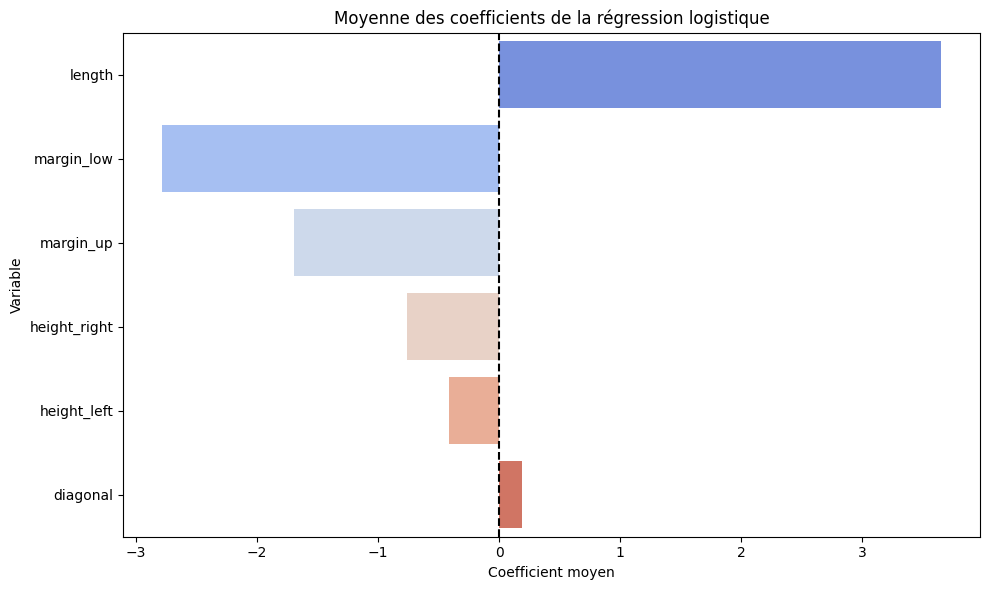


=== Moyenne des coefficients sur 10 folds ===
    Variable  Coefficient moyen  Écart-type
      length           3.651515    0.085821
  margin_low          -2.783759    0.057364
   margin_up          -1.695021    0.047339
height_right          -0.759204    0.057835
 height_left          -0.410240    0.036196
    diagonal           0.192523    0.048351


In [ ]:
coefficients_list = []
feature_names = X.columns

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]

    X_train_scaled = scaler.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)

    coefficients_list.append(model.coef_[0])

coef_array = np.array(coefficients_list)
coef_mean = coef_array.mean(axis=0)
coef_std = coef_array.std(axis=0)

coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient moyen': coef_mean,
    'Écart-type': coef_std
}).sort_values(by='Coefficient moyen', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient moyen', y='Variable', palette='coolwarm', orient='h')
plt.axvline(0, color='black', linestyle='--')
plt.title("Moyenne des coefficients de la régression logistique")
plt.xlabel("Coefficient moyen")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

print("\n=== Moyenne des coefficients sur 10 folds ===")
print(coef_df.to_string(index=False))

### C) K-Means

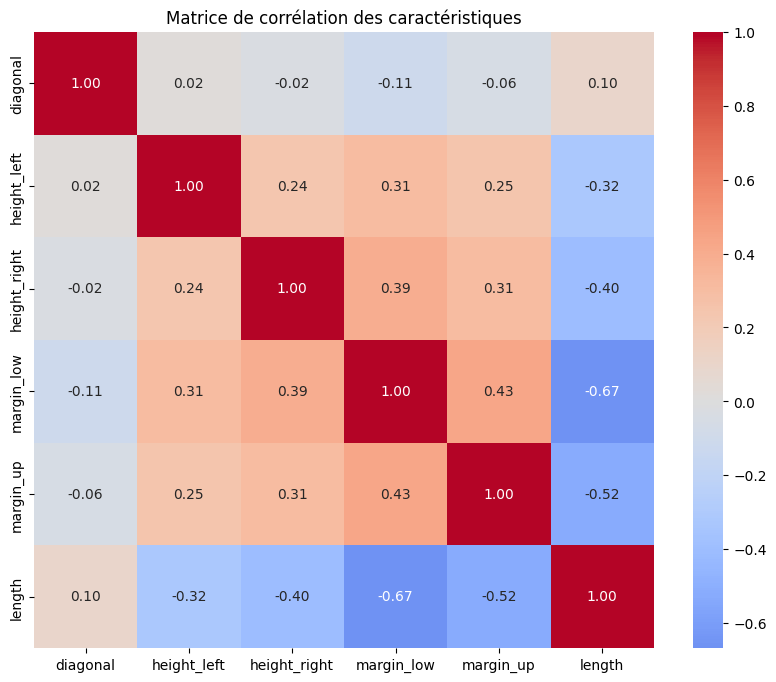


Fold 1:
Train - Acc: 0.983, Prec: 0.985, Rec: 0.990, F1: 0.987
Test  - Acc: 0.993, Prec: 1.000, Rec: 0.990, F1: 0.995

Fold 2:
Train - Acc: 0.984, Prec: 0.988, Rec: 0.989, F1: 0.988
Test  - Acc: 0.987, Prec: 0.980, Rec: 1.000, F1: 0.990

Fold 3:
Train - Acc: 0.987, Prec: 0.989, Rec: 0.991, F1: 0.990
Test  - Acc: 0.967, Prec: 0.970, Rec: 0.980, F1: 0.975

Fold 4:
Train - Acc: 0.984, Prec: 0.986, Rec: 0.991, F1: 0.988
Test  - Acc: 0.993, Prec: 1.000, Rec: 0.990, F1: 0.995

Fold 5:
Train - Acc: 0.987, Prec: 0.989, Rec: 0.991, F1: 0.990
Test  - Acc: 0.967, Prec: 0.970, Rec: 0.980, F1: 0.975

Fold 6:
Train - Acc: 0.984, Prec: 0.986, Rec: 0.991, F1: 0.988
Test  - Acc: 0.987, Prec: 1.000, Rec: 0.980, F1: 0.990

Fold 7:
Train - Acc: 0.984, Prec: 0.987, Rec: 0.989, F1: 0.988
Test  - Acc: 0.993, Prec: 0.990, Rec: 1.000, F1: 0.995

Fold 8:
Train - Acc: 0.982, Prec: 0.985, Rec: 0.989, F1: 0.987
Test  - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000

Fold 9:
Train - Acc: 0.984, Prec: 0.987, Rec: 0

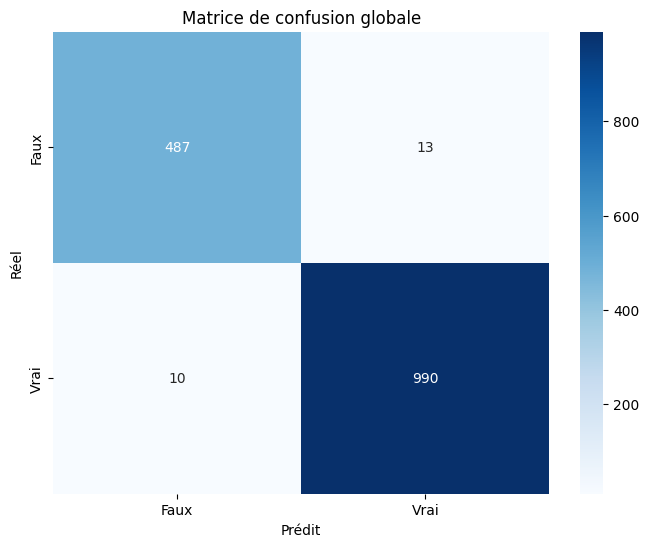

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def map_clusters_to_labels(y_train, clusters_train):
    """Associe à chaque cluster le label majoritaire dans le train."""
    mapping = {}
    for cluster in np.unique(clusters_train):
        mask = clusters_train == cluster
        majority_label = np.bincount(y_train[mask]).argmax()
        mapping[cluster] = majority_label
    return mapping

scaler = StandardScaler()
results = {
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_rec': [], 'test_rec': [],
    'train_f1': [], 'test_f1': []
}
y_true_all = []
y_pred_all = []

# 1. Matrice de corrélation avant traitement
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Matrice de corrélation des caractéristiques")
plt.show()

# 2. Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx].values, y.iloc[test_idx].values

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters_train = kmeans.fit_predict(X_train_scaled)

    cluster_label_map = map_clusters_to_labels(y_train, clusters_train)
    y_pred_train = np.array([cluster_label_map[c] for c in clusters_train])
    y_pred_test = np.array([cluster_label_map[c] for c in kmeans.predict(X_test_scaled)])

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test)

    results['train_acc'].append(accuracy_score(y_train, y_pred_train))
    results['train_prec'].append(precision_score(y_train, y_pred_train))
    results['train_rec'].append(recall_score(y_train, y_pred_train))
    results['train_f1'].append(f1_score(y_train, y_pred_train))

    results['test_acc'].append(accuracy_score(y_test, y_pred_test))
    results['test_prec'].append(precision_score(y_test, y_pred_test))
    results['test_rec'].append(recall_score(y_test, y_pred_test))
    results['test_f1'].append(f1_score(y_test, y_pred_test))

    print(f"\nFold {fold}:")
    print(f"Train - Acc: {results['train_acc'][-1]:.3f}, Prec: {results['train_prec'][-1]:.3f}, Rec: {results['train_rec'][-1]:.3f}, F1: {results['train_f1'][-1]:.3f}")
    print(f"Test  - Acc: {results['test_acc'][-1]:.3f}, Prec: {results['test_prec'][-1]:.3f}, Rec: {results['test_rec'][-1]:.3f}, F1: {results['test_f1'][-1]:.3f}")

# 3. Résultats globaux
print("\n=== PERFORMANCES MOYENNES ===")
print(f"{'Métrique':<10} | {'Train':^8} | {'Test':^8} | {'Gap':^6}")
print("-"*40)
for metric in ['acc', 'prec', 'rec', 'f1']:
    train_mean = np.mean(results[f'train_{metric}'])
    test_mean = np.mean(results[f'test_{metric}'])
    print(f"{metric.upper():<10} | {train_mean:.3f}    | {test_mean:.3f}    | {train_mean-test_mean:+.3f}")

# 4. Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faux', 'Vrai'],
            yticklabels=['Faux', 'Vrai'])
plt.title('Matrice de confusion globale')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()



### Modèle KNN


Fold 1:
Train - Accuracy: 0.991, Precision: 0.989, Recall: 0.998, F1: 0.993
Test  - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000

Fold 2:
Train - Accuracy: 0.991, Precision: 0.989, Recall: 0.998, F1: 0.993
Test  - Accuracy: 0.993, Precision: 0.990, Recall: 1.000, F1: 0.995

Fold 3:
Train - Accuracy: 0.993, Precision: 0.990, Recall: 0.999, F1: 0.994
Test  - Accuracy: 0.980, Precision: 0.980, Recall: 0.990, F1: 0.985

Fold 4:
Train - Accuracy: 0.991, Precision: 0.989, Recall: 0.998, F1: 0.993
Test  - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1: 1.000

Fold 5:
Train - Accuracy: 0.994, Precision: 0.992, Recall: 0.999, F1: 0.996
Test  - Accuracy: 0.973, Precision: 0.962, Recall: 1.000, F1: 0.980

Fold 6:
Train - Accuracy: 0.992, Precision: 0.990, Recall: 0.998, F1: 0.994
Test  - Accuracy: 0.993, Precision: 0.990, Recall: 1.000, F1: 0.995

Fold 7:
Train - Accuracy: 0.991, Precision: 0.989, Recall: 0.998, F1: 0.993
Test  - Accuracy: 0.993, Precision: 0.990, Recall: 1.

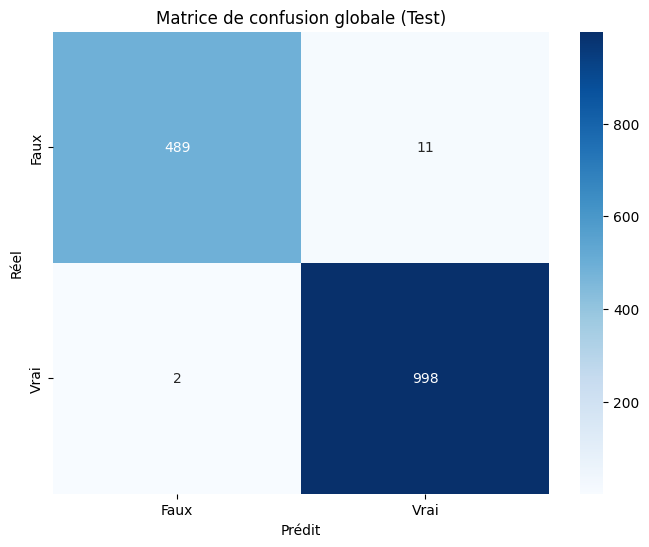

In [ ]:
# 1. Initialisation
model = KNeighborsClassifier(n_neighbors=11)
scaler = StandardScaler()

# 2. Stockage des résultats
results = {
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_rec': [], 'test_rec': [],
    'train_f1': [], 'test_f1': []
}
y_true_all = []
y_pred_all = []

# 3. Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test)

    results['train_acc'].append(accuracy_score(y_train, y_pred_train))
    results['train_prec'].append(precision_score(y_train, y_pred_train))
    results['train_rec'].append(recall_score(y_train, y_pred_train))
    results['train_f1'].append(f1_score(y_train, y_pred_train))

    results['test_acc'].append(accuracy_score(y_test, y_pred_test))
    results['test_prec'].append(precision_score(y_test, y_pred_test))
    results['test_rec'].append(recall_score(y_test, y_pred_test))
    results['test_f1'].append(f1_score(y_test, y_pred_test))

    print(f"\nFold {fold}:")
    print(f"Train - Accuracy: {results['train_acc'][-1]:.3f}, Precision: {results['train_prec'][-1]:.3f}, Recall: {results['train_rec'][-1]:.3f}, F1: {results['train_f1'][-1]:.3f}")
    print(f"Test  - Accuracy: {results['test_acc'][-1]:.3f}, Precision: {results['test_prec'][-1]:.3f}, Recall: {results['test_rec'][-1]:.3f}, F1: {results['test_f1'][-1]:.3f}")

# 4. Analyse des écarts
print("\n" + "="*60)
print("RÉSULTATS GLOBAUX".center(60))
print("="*60)

print("\n=== PERFORMANCES MOYENNES ===")
print(f"{'Métrique':<12} | {'Train':^8} | {'Test':^8} | {'Gap':^8} | {'Écart-type (Test)':^15}")
print("-"*60)
for metric in ['acc', 'prec', 'rec', 'f1']:
    train_mean = np.mean(results[f'train_{metric}'])
    test_mean = np.mean(results[f'test_{metric}'])
    gap = train_mean - test_mean
    std = np.std(results[f'test_{metric}'])

    print(f"{metric.capitalize():<12} | {train_mean:.3f}    | {test_mean:.3f}    | {gap:+.3f}    | {std:.3f}")

# 5. Matrice de confusion globale
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faux', 'Vrai'],
            yticklabels=['Faux', 'Vrai'])
plt.title('Matrice de confusion globale (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()



### D) Moidèle Random Forest


Fold 1:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000

Fold 2:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 0.993, Prec: 0.990, Rec: 1.000, F1: 0.995

Fold 3:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 0.973, Prec: 0.980, Rec: 0.980, F1: 0.980

Fold 4:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000

Fold 5:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 0.980, Prec: 0.971, Rec: 1.000, F1: 0.985

Fold 6:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 0.993, Prec: 0.990, Rec: 1.000, F1: 0.995

Fold 7:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 0.993, Prec: 0.990, Rec: 1.000, F1: 0.995

Fold 8:
Train - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000
Test  - Acc: 1.000, Prec: 1.000, Rec: 1.000, F1: 1.000

Fold 9:
Train - Acc: 1.000, Prec: 1.000, Rec: 1

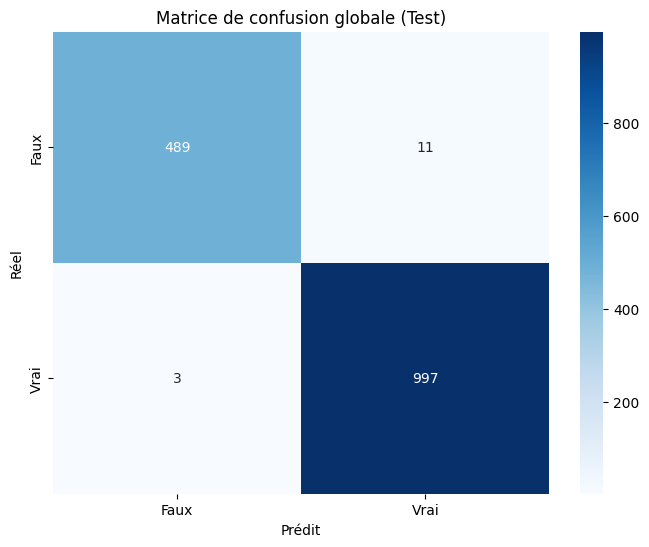

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Initialisation
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Stockage des résultats
results = {
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_rec': [], 'test_rec': [],
    'train_f1': [], 'test_f1': []
}
y_true_all = []
y_pred_all = []

# 3. Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test)

    results['train_acc'].append(accuracy_score(y_train, y_pred_train))
    results['train_prec'].append(precision_score(y_train, y_pred_train))
    results['train_rec'].append(recall_score(y_train, y_pred_train))
    results['train_f1'].append(f1_score(y_train, y_pred_train))

    results['test_acc'].append(accuracy_score(y_test, y_pred_test))
    results['test_prec'].append(precision_score(y_test, y_pred_test))
    results['test_rec'].append(recall_score(y_test, y_pred_test))
    results['test_f1'].append(f1_score(y_test, y_pred_test))

    print(f"\nFold {fold}:")
    print(f"Train - Acc: {results['train_acc'][-1]:.3f}, Prec: {results['train_prec'][-1]:.3f}, Rec: {results['train_rec'][-1]:.3f}, F1: {results['train_f1'][-1]:.3f}")
    print(f"Test  - Acc: {results['test_acc'][-1]:.3f}, Prec: {results['test_prec'][-1]:.3f}, Rec: {results['test_rec'][-1]:.3f}, F1: {results['test_f1'][-1]:.3f}")

# 4. Analyse des écarts
print("\n" + "="*60)
print("RÉSULTATS GLOBAUX".center(60))
print("="*60)

print("\n=== PERFORMANCES MOYENNES ===")
print(f"{'Métrique':<12} | {'Train':^8} | {'Test':^8} | {'Gap':^8} | {'Écart-type (Test)':^15}")
print("-"*60)
for metric in ['acc', 'prec', 'rec', 'f1']:
    train_mean = np.mean(results[f'train_{metric}'])
    test_mean = np.mean(results[f'test_{metric}'])
    gap = train_mean - test_mean
    std = np.std(results[f'test_{metric}'])

    print(f"{metric.capitalize():<12} | {train_mean:.3f}    | {test_mean:.3f}    | {gap:+.3f}    | {std:.3f}")

# 5. Matrice de confusion globale
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faux', 'Vrai'],
            yticklabels=['Faux', 'Vrai'])
plt.title('Matrice de confusion globale (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()




### G) Entrainement du modèle le plus performant

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# 1. Séparation des variables
X = billets.drop(columns=["is_genuine"])
y = billets["is_genuine"]

# 2. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Entraînement du modèle KNN
reg = LogisticRegression()
reg.fit(X_scaled, y)

LogisticRegression()

### Sauvegarde du modèle

In [ ]:

import joblib

# Sauvegarde du scaler
joblib.dump(scaler, path+'scaler.joblib')

# Sauvegarde du modèle de régression logistique
joblib.dump(reg, path+'reg_prediction_billets.joblib')

print("Modèle et scaler sauvegardés")

Modèle et scaler sauvegardés
